# Сверточная нейросеть для решения задачи классификации картинок

На этом практическом занятии мы построим сверточную нейросеть и решим задачу классификации картинок CIFAR с ее помощью.


## Загрузка датасета


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms

В PyTorch есть модуль datasets, которые предоставляют доступ ко многим стандартным датасетам. CIFAR — один из них. Давайте загрузим его:

In [ ]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10_data
    Split: Train
    StandardTransform
Transform: ToTensor()

Поделим train_data на тренировочную и валидационную выборку:

In [ ]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Заведем DataLoader'ы для каждой части датасета:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Посмотрим на несколько картинок:

In [ ]:
for batch in train_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [ ]:
images.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [ ]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

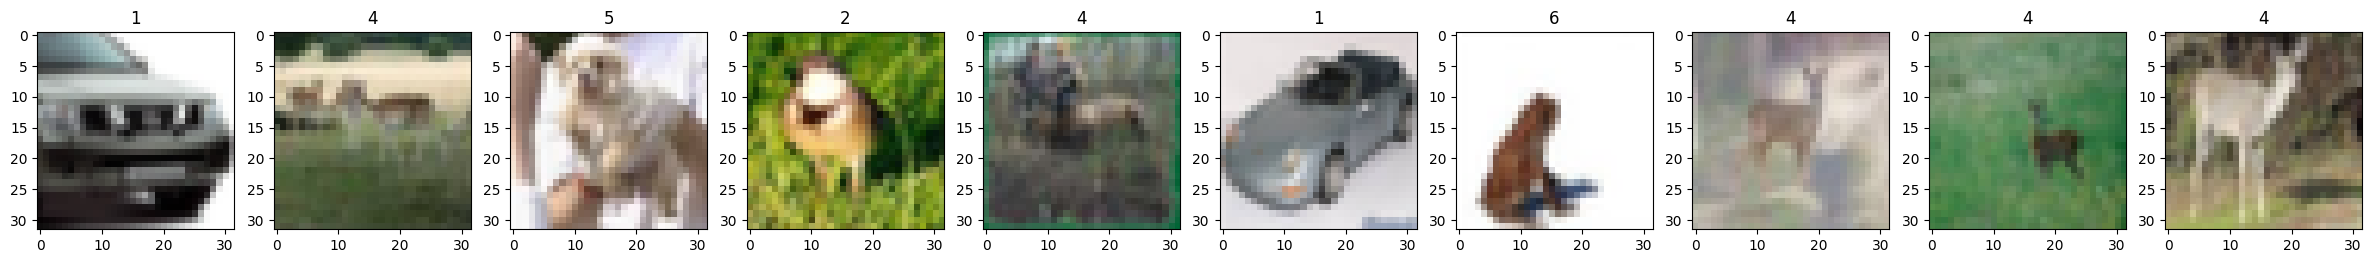

In [ ]:
show_images(images, labels)

Таблица соответствий номеров ответов и классов:

| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      |
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


Создадим словарь соответствий номера и названия, чтобы проще интерпретировать выход нейронной сети:

In [ ]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}

## Определение класса сверточной нейросети

Импортируем нужные модули для обучения сети:

In [ ]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F
# метрика качества
from sklearn.metrics import accuracy_score

Объявим сверточную нейросеть.

Наша нейронная сеть будет сожержать четыре слоя: два сверточных и два полносвязных. Также после первого сверточного слоя добавим pooling. В качестве функции активации для внутренних слоев будем использовать ReLU.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # размер исходной картинки 32х32

        # conv 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3), padding=1) #32x32
        # pool
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #16x16
        # conv 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3)) #14x14

        # flatten
        self.flatten = nn.Flatten()

        # linear 1
        self.fc1 = nn.Linear(14 * 14 * 9, 128)
        # linear 2
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        # forward pass сети

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# проверим, доступен ли GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# объявляем сеть
conv_net = ConvNet().to(device)

cuda


## Обучение нейросети

In [ ]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

Напишем функцию обучения сети:

In [ ]:
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn=None):

    y_pred_list = []
    y_true_list = []

    losses = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch

        with torch.no_grad():
            logits = model(X_batch.to(device))

            if loss_fn is not None:
                loss = loss_fn(logits, y_batch.to(device))
                losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())


    accuracy = accuracy_score(y_pred_list, y_true_list)

    return accuracy, np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):

    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    # цикл обучения сети
    for epoch in range(n_epoch):

        model.train(True)

        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # выведем лосс на график раз в 50 итераций обучения
            if i % 50 == 0:

                fig, axes = plt.subplots(2, 2, figsize=(14, 10))

                train_losses.append(loss.item())

                # вычислим accuracy на текущем train батче
                model_answers = torch.argmax(logits, dim=1)
                train_accuracy = accuracy_score(y_batch.numpy(), model_answers.cpu().numpy())
                train_accuracies.append(train_accuracy)

                train_iterations = np.array(range(len(train_losses)))*50

                # отрисовываем train_losses
                axes[0, 0].plot(train_iterations, train_losses)
                axes[0, 0].set_title('Train losses')
                axes[0, 0].set(xlabel='Iterations', ylabel='Loss')

                # отрисовываем train_accuracies
                axes[0, 1].plot(train_iterations, train_accuracies)
                axes[0, 1].set_title('Train accuracies')
                axes[0, 1].set(xlabel='Iterations', ylabel='Accuracy')

                val_iterations = np.array(range(len(val_losses)))*50

                axes[1, 0].plot(val_iterations, val_losses)
                axes[1, 0].set_title('Val losses')
                axes[1, 0].set(xlabel='Iterations', ylabel='Loss')

                axes[1, 1].plot(val_iterations, val_accuracies)
                axes[1, 1].set_title('Val accuracies')
                axes[1, 1].set(xlabel='Iterations', ylabel='Accuracy')

                plt.show()

                clear_output(wait=True)

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return model, train_losses, val_losses, val_accuracies

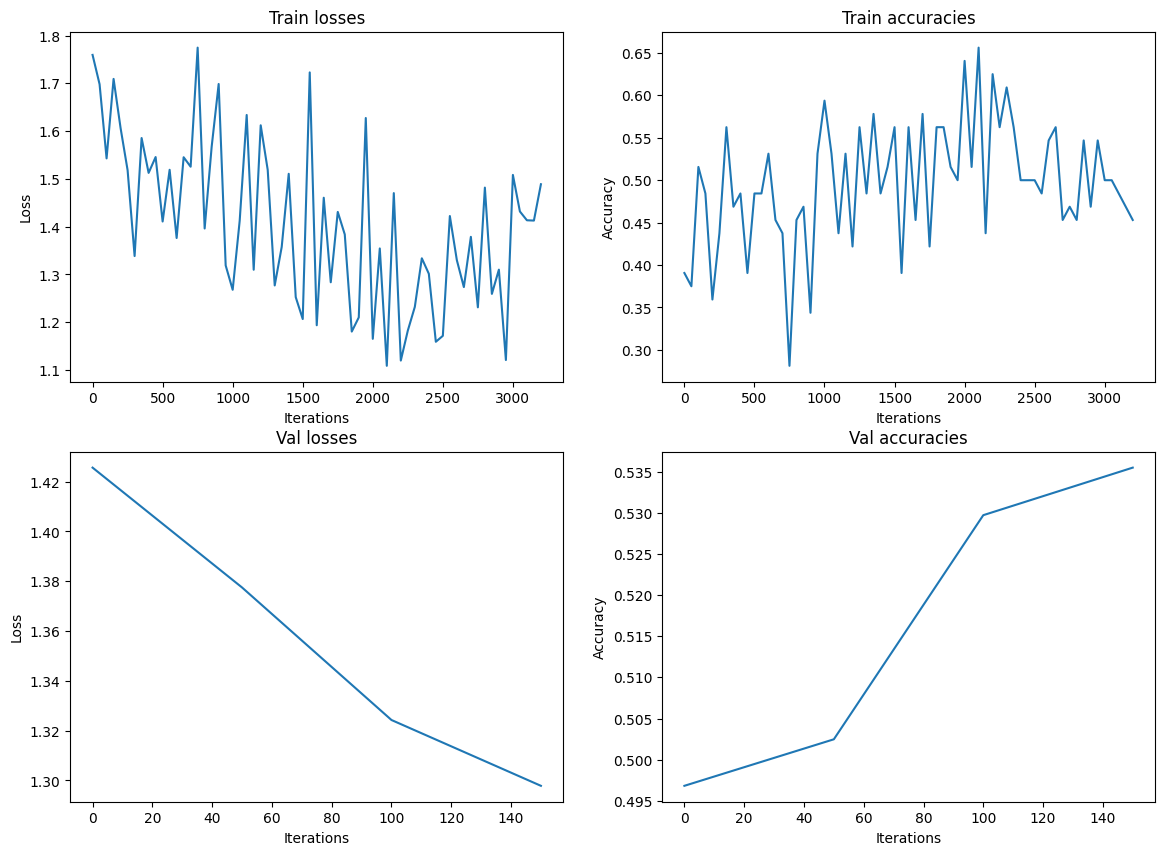

In [ ]:
conv_net, train_losses_conv, val_losses_conv, val_accuracies_conv = train(conv_net, loss_fn, optimizer, n_epoch=5)

Визуализируем значение лосс-функции на train и val выборках на одном графике:

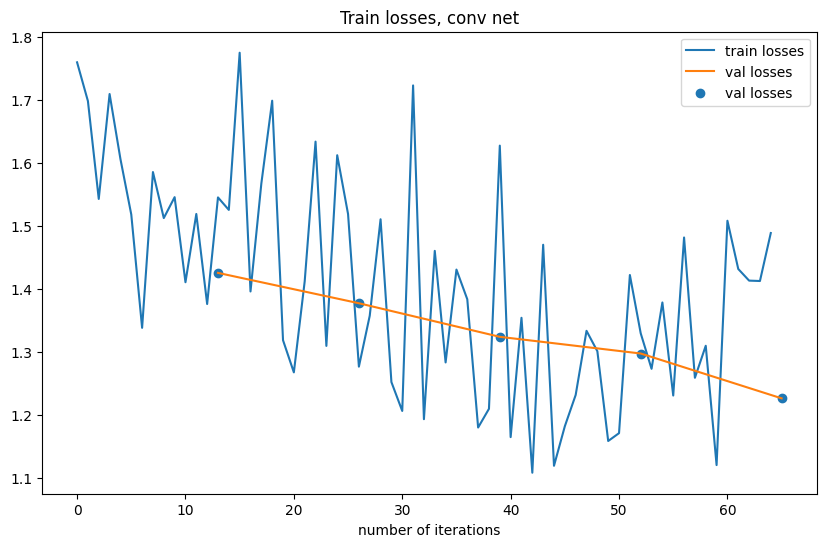

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Train losses, conv net')
plt.plot(np.arange(len(train_losses_conv)), train_losses_conv, label='train losses')
plt.plot(np.arange(1, len(val_losses_conv) + 1) * (len(train_losses_conv) // len(val_losses_conv)),
         val_losses_conv, label='val losses')
plt.scatter(np.arange(1, len(val_losses_conv) + 1) * (len(train_losses_conv) // len(val_losses_conv)),
         val_losses_conv, label='val losses')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

Посчитаем итоговый accuracy на train и test выборках:

In [ ]:
train_accuracy, _ = evaluate(conv_net, train_loader);
print('Train accuracy is', train_accuracy)

Train accuracy is 0.5657


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
val_accuracy, _ = evaluate(conv_net, val_loader);
print('Val accuracy is', val_accuracy)

Val accuracy is 0.5657


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
test_accuracy, _ = evaluate(conv_net, test_loader);
print('Test accuracy is', test_accuracy)

Test accuracy is 0.542


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Что еще можно добавить в сеть:

- BatchNorm. Его добавляют как после сверточных слоев, так и после полносвязных. Однако если для полносвязных слоев использовался [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), то для сверточных слоев нужен [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Разница в том, что выход сверточного слоя уже не одномерный, как у линейного, а двумерный, и статистики (среднее и дисперсию) нужно считать по двум размерностям
- Dropout. Его чаще всего добавляют только после линейных слоев
- Разные варианты Pooling'ов: [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) и [другие](https://pytorch.org/docs/stable/nn.html#pooling-layers)